In [81]:
import numpy as np
from neuralStellar import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import os

In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_30/small_grid_model.h5')
m1.getWeights()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
_________________________________________________________

# Create the pseudo-cluster data from NN

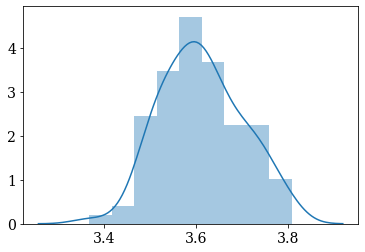

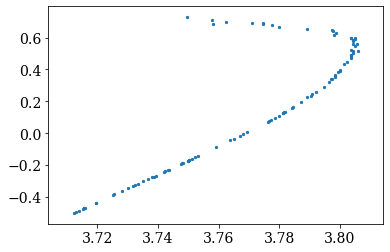

In [66]:
iso_age = 3.6
spread = 0.1
N = 100
Tage = np.random.randn(N)*spread+iso_age
sns.distplot(Tage)
plt.show()
Tmass = np.random.rand(N)*(1.35-0.8)+0.8
Tfeh = np.zeros(N)
TMLT = np.ones(N)*1.9

Tinputs = np.log10(np.vstack((Tmass, Tage, 10**Tfeh, 10**TMLT)))
Toutputs = m1.model.predict(Tinputs.T).T
[TL, TTeff, Tdelnu] = 10**Toutputs
plt.scatter(np.log10(TTeff), np.log10(TL), s=5)
plt.show()

# HBM!!

In [67]:
model = pm.Model()
with model:
    Age_mu = pm.Normal('mean_age', 3.6, 0.2)
    Age_sigma = pm.Lognormal('spread_age', T.log(0.1), 0.1)
    Age = pm.Normal('age', Age_mu, Age_sigma, shape=N)
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(1.35-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict([T.log10(M), T.log10(Age), feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0,:],0.1, observed=TL)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1,:],70, observed=TTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)

[Elemwise{log10,no_inplace}.0, Elemwise{log10,no_inplace}.0, feh, MLT]


In [68]:
start = {'mean_age':3.6, 'spread_age':0.1}
with model:
    trace = pm.sample(tune=5000, init='adapt_diag', start=start, target_accept=0.99, cores=1, chains=2)
    #mean_field = pm.fit(n=50000, method='advi')
    #advi = pm.ADVI()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [c, age, spread_age, mean_age]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [86]:
file = 'pymc3_traces/NNcluster1'
os.mkdir(file)
pm.save_trace(trace, directory=file+'/', overwrite=True)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'pymc3_traces/NNcluster1'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013A3CD47550>,
      dtype=object)

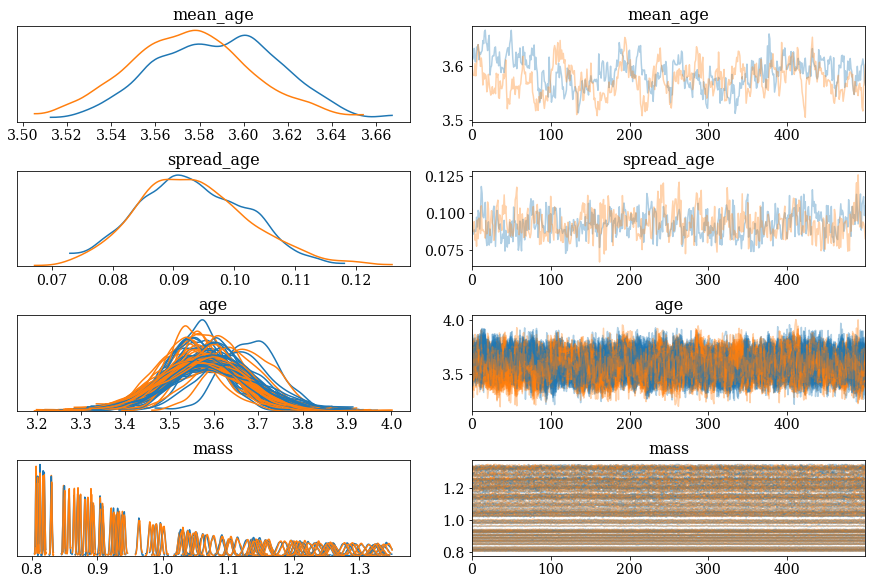

In [69]:
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','age','mass'],compact=True)

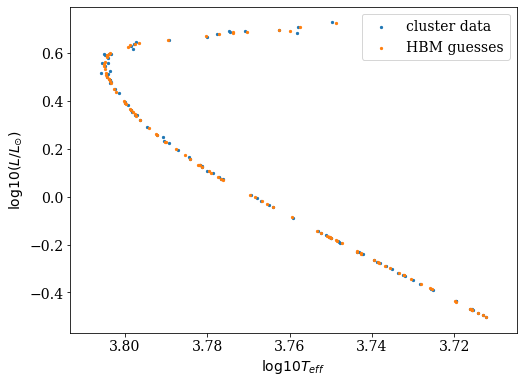

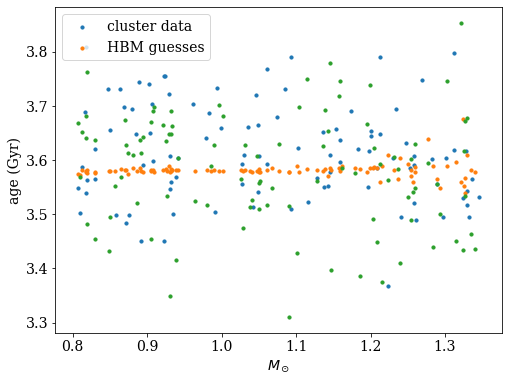

In [94]:
from matplotlib import rc
rc("font", family="serif", size=14)
mean_ages=np.mean(trace['age'],axis=0)
mean_masses = np.mean(trace['mass'],axis=0)
Finputs = np.log10(np.vstack((mean_masses, mean_ages, 10**Tfeh, 10**TMLT)))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(np.log10(TTeff), np.log10(TL), s=5, label='cluster data')
ax.scatter(np.log10(FTeff), np.log10(FL), s=5, label='HBM guesses')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(Tmass, Tage,s=10, label='cluster data')
ax.scatter(mean_masses, mean_ages, s=10, label='HBM guesses')
ax.scatter(mean_masses, np.random.randn(N)*np.mean(trace['spread_age'])+np.mean(trace['mean_age']),s=10)
ax.set_xlabel(r'$M_\odot$')
ax.set_ylabel(r'age (Gyr)')
ax.legend()
plt.show()

In [71]:
pm.summary(trace, var_names=['mean_age','spread_age','age','mass'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,3.582,0.029,3.528,3.636,0.004,0.003,46.0,46.0,47.0,121.0,1.04
spread_age,0.093,0.009,0.078,0.110,0.001,0.000,301.0,300.0,307.0,487.0,1.00
age[0],3.586,0.086,3.424,3.741,0.003,0.002,864.0,853.0,853.0,718.0,1.00
age[1],3.582,0.093,3.400,3.739,0.004,0.003,519.0,511.0,574.0,640.0,1.01
age[2],3.580,0.104,3.392,3.772,0.004,0.003,579.0,576.0,565.0,719.0,1.00
age[3],3.581,0.100,3.398,3.767,0.004,0.003,620.0,620.0,617.0,598.0,1.00
age[4],3.581,0.094,3.409,3.754,0.004,0.003,589.0,581.0,580.0,872.0,1.00
age[5],3.564,0.087,3.383,3.715,0.003,0.002,678.0,678.0,676.0,878.0,1.00
age[6],3.582,0.096,3.398,3.751,0.004,0.003,516.0,516.0,508.0,826.0,1.00
age[7],3.577,0.084,3.419,3.729,0.003,0.002,823.0,823.0,817.0,772.0,1.00


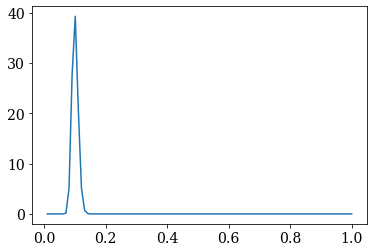

In [54]:
x=np.linspace(0,1,100)
mu=np.log(0.1)
sigma=0.1
y=(1/x)/(sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
plt.plot(x,y)

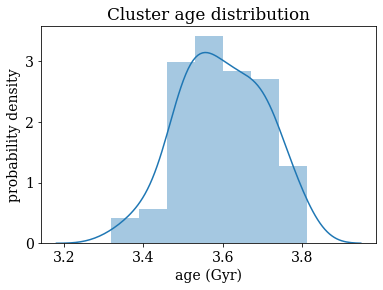

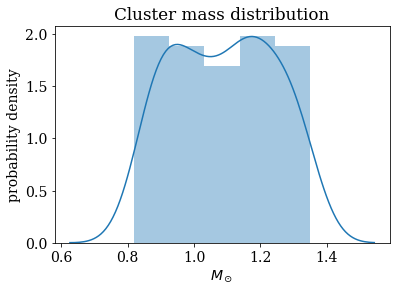

In [63]:
sns.distplot(Tage)
plt.xlabel('age (Gyr)')
plt.ylabel('probability density')
plt.title('Cluster age distribution')
plt.show()
sns.distplot(Tmass)
plt.xlabel(r'$M_\odot$')
plt.ylabel('probability density')
plt.title('Cluster mass distribution')
plt.show()